# Sample Analysis with Sodapy and Socrata Query Language (SoQL)
Mark Bauer

Table of Contents
=================

   1. Introduction
   2. Importing Libraries
   3. Answering Questions about NYC 311 Complaints
       * 3.1 Most NYC 311 Complaints by Complaint Type
       * 3.2 Most NYC 311 Complaints by Day
       * 3.3 Analyzing NYC 311 Datasets with the Most Downloads
       * 3.4 Analyzing NYC 311 Datasets with the Most Page Views
   4. Answering questions about NYC 311 Street Flooding Complaints
       * 4.1 Searching the dataset for the word "flood" in the complaint_type field
       * 4.2 Searching the dataset for the word "flood" in the descriptor field
       * 4.3 Displaying the highest number of street flooding complaints by day
       * 4.4 Selecting the rows and columns where the descriptor field = 'Street Flooding'      

# 1. Introduction  
This notebook demonstrates a basic analysis using SoQL, the Socrata Query Language. 

# 2. Importing Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import urllib.parse

sns.set_theme()
plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
## documention for installing watermark: https://github.com/rasbt/watermark
%reload_ext watermark
%watermark -t -d -v -p pandas,sodapy

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

pandas: 1.4.2
sodapy: 2.2.0



# 3. Answering Questions about NYC 311 Complaints with SoQL

### Note:  
`WARNING:root:Requests made without an app_token will be subject to strict throttling limits.`

Read more from the SODA documentation here: https://dev.socrata.com/docs/app-tokens.html

## 3.1 Most NYC 311 Complaints by Complaint Type

In [3]:
# Source domain for NYC Open Data on Socrata
socrata_domain = 'data.cityofnewyork.us'

# Dataset id for NYC 311 on NYC Open Data on Socrata
socrata_dataset_identifier = 'erm2-nwe9'

""" Socrata - The main class that interacts with the SODA API. We pass the source domain value
of NYC Open data, the app token as 'None', and set the timeout parameter for '1,000 seconds'
"""
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the complaint_type and the count of complaint_type columns 
grouped by complaint_type, sorted by the count of complaint_type in descending order
and limit our records to 10
"""

query = """
SELECT 
    complaint_type, 
    count(unique_key) AS count
GROUP BY 
    complaint_type
ORDER BY 
    count DESC
LIMIT 
    10
"""

""" Requesting data from the NYC 311 dataset
and passing our query as a full SoQL query string
"""
results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (10, 2)


,complaint_type,count
0,Noise - Residential,3119660
1,Illegal Parking,2089233
2,HEAT/HOT WATER,1981903
3,Blocked Driveway,1432917
4,Street Condition,1209366
5,Street Light Condition,1114277
6,Noise - Street/Sidewalk,1090914
7,Request Large Bulky Item Collection,1073753
8,PLUMBING,888075
9,HEATING,887869


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   complaint_type  10 non-null     object
 1   count           10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


In [5]:
# cast as int and convert to MM
df['count'] = df['count'].astype(int) / 1e6

# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   complaint_type  10 non-null     object 
 1   count           10 non-null     float64
dtypes: float64(1), object(1)
memory usage: 288.0+ bytes


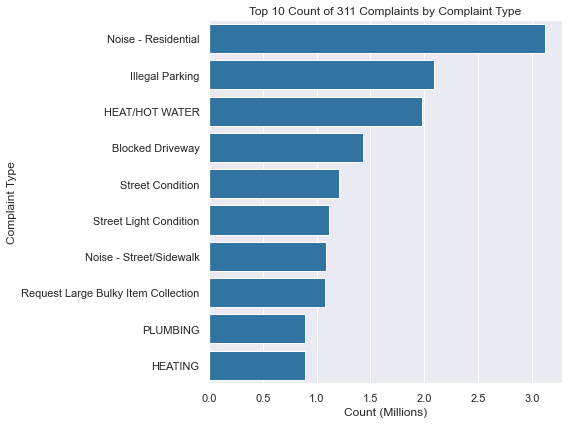

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

data = df.sort_values(by='count', ascending=False)

sns.barplot(
    data=data,
    y='complaint_type',
    x='count',
    color='#1f77b4',
    ax=ax
)

plt.title('Top 10 Count of 311 Complaints by Complaint Type')
plt.xlabel('Count (Millions)')
plt.ylabel('Complaint Type')
plt.tight_layout()
plt.savefig('figures/complaint-type.png', dpi=250, bbox_inches='tight')

In [7]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the complaint_type and the count of complaint_type columns 
grouped by complaint_type, sorted by the count of complaint_type in descending order
and limit our records to 10
"""

query = """
SELECT 
    complaint_type, 
    descriptor,
    count(unique_key) AS count
GROUP BY 
    complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    10
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (10, 3)


,complaint_type,descriptor,count
0,Noise - Residential,Loud Music/Party,2087237
1,HEAT/HOT WATER,ENTIRE BUILDING,1293140
2,Request Large Bulky Item Collection,Request Large Bulky Item Collection,1073753
3,Blocked Driveway,No Access,1069866
4,HEATING,HEAT,868960
5,Noise - Street/Sidewalk,Loud Music/Party,851494
6,Street Light Condition,Street Light Out,821045
7,Noise - Residential,Banging/Pounding,792026
8,Street Condition,Pothole,732697
9,HEAT/HOT WATER,APARTMENT ONLY,688763


In [8]:
# cast to int and convert to MM
df['count'] = df['count'].astype(int) / 1e6
df['type_full'] = df['complaint_type'] + ':\n' + df['descriptor']

# sanity check
df.head()

,complaint_type,descriptor,count,type_full
0,Noise - Residential,Loud Music/Party,2.087237,Noise - Residential:\nLoud Music/Party
1,HEAT/HOT WATER,ENTIRE BUILDING,1.293140,HEAT/HOT WATER:\nENTIRE BUILDING
2,Request Large Bulky Item Collection,Request Large Bulky Item Collection,1.073753,Request Large Bulky Item Collection:\nRequest ...
3,Blocked Driveway,No Access,1.069866,Blocked Driveway:\nNo Access
4,HEATING,HEAT,0.868960,HEATING:\nHEAT


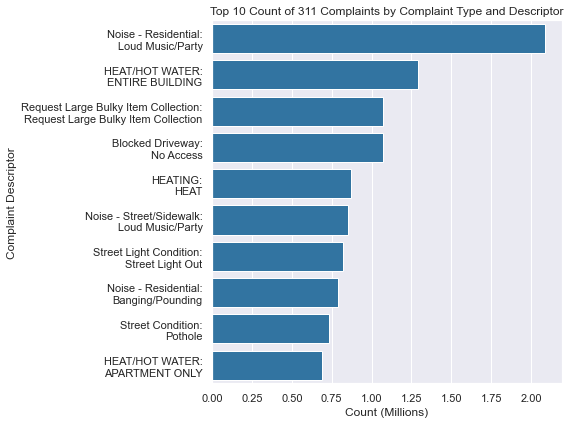

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

data = df.sort_values(by='count', ascending=False)

sns.barplot(
    data=data,
    y='type_full',
    x='count',
    color='#1f77b4',
    ax=ax
)

plt.title('Top 10 Count of 311 Complaints by Complaint Type and Descriptor')
plt.xlabel('Count (Millions)')
plt.ylabel('Complaint Descriptor')
plt.tight_layout()
plt.savefig('figures/descriptor-type.png', dpi=250, bbox_inches='tight')

## 3.2 Most NYC 311 Complaints by Day

In [10]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day, 
    count(unique_key) AS count
GROUP BY 
    day
ORDER BY 
    count DESC
LIMIT 
    10
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (10, 2)


,day,count
0,2020-08-04T00:00:00.000,24415
1,2020-08-05T00:00:00.000,19560
2,2020-07-05T00:00:00.000,16916
3,2020-06-21T00:00:00.000,15883
4,2020-06-20T00:00:00.000,15825
5,2020-07-04T00:00:00.000,15794
6,2021-09-02T00:00:00.000,15205
7,2020-06-28T00:00:00.000,14057
8,2021-10-28T00:00:00.000,13575
9,2020-08-06T00:00:00.000,13288


In [11]:
# casting to different dtypes
df['day_fmt'] = pd.to_datetime(df['day']).astype(str)
df['count'] = df['count'].astype(int)

# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   day      10 non-null     object
 1   count    10 non-null     int64 
 2   day_fmt  10 non-null     object
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


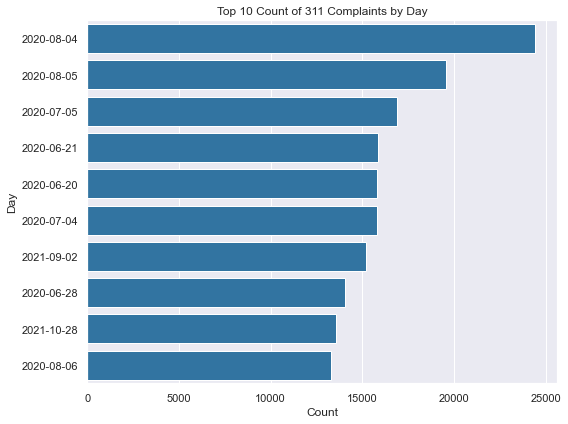

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

data = df.sort_values(by='count', ascending=False)

sns.barplot(
    data=data,
    y='day_fmt',
    x='count',
    color='#1f77b4',
    ax=ax
)

plt.title('Top 10 Count of 311 Complaints by Day')
plt.xlabel('Count')
plt.ylabel('Day')
plt.tight_layout()
plt.savefig('figures/day-top.png', dpi=250, bbox_inches='tight')

## Extra: Lineplot of NYC 311 Complaints by Day

In [13]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day, 
    count(unique_key) AS count
GROUP BY 
    day
ORDER BY 
    count DESC
LIMIT 
    10000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (4948, 2)


,day,count
0,2020-08-04T00:00:00.000,24415
1,2020-08-05T00:00:00.000,19560
2,2020-07-05T00:00:00.000,16916
3,2020-06-21T00:00:00.000,15883
4,2020-06-20T00:00:00.000,15825
5,2020-07-04T00:00:00.000,15794
6,2021-09-02T00:00:00.000,15205
7,2020-06-28T00:00:00.000,14057
8,2021-10-28T00:00:00.000,13575
9,2020-08-06T00:00:00.000,13288


In [14]:
# cast day to datetime and count as int and save out CSV
df['day_fmt'] = pd.to_datetime(df['day'])
df['count']  = df['count'].astype(int)

df.to_csv('data-output/complaints-day.csv', index=False)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4948 entries, 0 to 4947
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   day      4948 non-null   object        
 1   count    4948 non-null   int64         
 2   day_fmt  4948 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 116.1+ KB


In [16]:
# removing last two days to prevent incomplete days
df = (
    df
    .sort_values(by='day_fmt')
    .iloc[:-2, :]
)

df.tail()

,day,count,day_fmt
286,2023-07-13T00:00:00.000,9677,2023-07-13
510,2023-07-14T00:00:00.000,9087,2023-07-14
1367,2023-07-15T00:00:00.000,7852,2023-07-15
1517,2023-07-16T00:00:00.000,7664,2023-07-16
220,2023-07-17T00:00:00.000,9946,2023-07-17


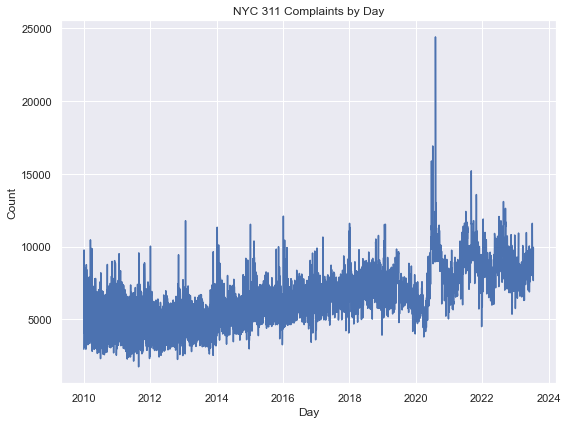

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    df
    .set_index('day_fmt')
    .loc[:, ['count']]
    .astype(int)
)

sns.lineplot(
    data=data,
    x=data.index,
    y='count',
    ax=ax
)

plt.title('NYC 311 Complaints by Day')
plt.xlabel('Day')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/day-line.png', dpi=250, bbox_inches='tight')

## Exploring complaints on the highest day

In [18]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2020-08-04T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    100
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (100, 4)


,day,complaint_type,descriptor,count
0,2020-08-04T00:00:00.000,Damaged Tree,Entire Tree Has Fallen Down,7848
1,2020-08-04T00:00:00.000,Damaged Tree,Branch or Limb Has Fallen Down,4971
2,2020-08-04T00:00:00.000,Damaged Tree,Branch Cracked and Will Fall,1330
3,2020-08-04T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,909
4,2020-08-04T00:00:00.000,Noise - Residential,Loud Music/Party,762
5,2020-08-04T00:00:00.000,Damaged Tree,Tree Leaning/Uprooted,510
6,2020-08-04T00:00:00.000,Street Light Condition,Street Light Out,397
7,2020-08-04T00:00:00.000,Traffic Signal Condition,Controller,353
8,2020-08-04T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,263
9,2020-08-04T00:00:00.000,Blocked Driveway,No Access,259


In [19]:
# casting as int
df['count'] = df['count'].astype(int)
df['type_full'] = df['complaint_type'] + ':\n' + df['descriptor']

df.head()

,day,complaint_type,descriptor,count,type_full
0,2020-08-04T00:00:00.000,Damaged Tree,Entire Tree Has Fallen Down,7848,Damaged Tree:\nEntire Tree Has Fallen Down
1,2020-08-04T00:00:00.000,Damaged Tree,Branch or Limb Has Fallen Down,4971,Damaged Tree:\nBranch or Limb Has Fallen Down
2,2020-08-04T00:00:00.000,Damaged Tree,Branch Cracked and Will Fall,1330,Damaged Tree:\nBranch Cracked and Will Fall
3,2020-08-04T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,909,Request Large Bulky Item Collection:\nRequest ...
4,2020-08-04T00:00:00.000,Noise - Residential,Loud Music/Party,762,Noise - Residential:\nLoud Music/Party


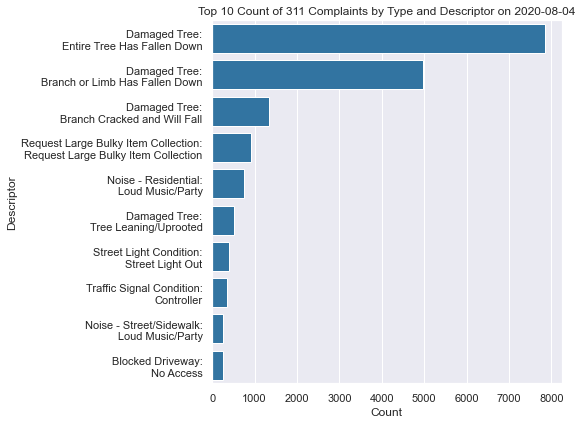

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='type_full',
    x='count',
    color='#1f77b4',
    ax=ax
)

# retrieve date string
date = data.head(1)['day'].str.split('T').values[0][0]
plt.title('Top 10 Count of 311 Complaints by Type and Descriptor on {}'.format(date))

plt.xlabel('Count')
plt.ylabel('Descriptor')
plt.tight_layout()
plt.savefig('figures/day-first.png', dpi=250, bbox_inches='tight')

## Exploring complaints on the second highest day

In [21]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2020-07-05T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    100
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (100, 4)


,day,complaint_type,descriptor,count
0,2020-07-05T00:00:00.000,Noise - Residential,Loud Music/Party,4334
1,2020-07-05T00:00:00.000,Illegal Fireworks,N/A,4199
2,2020-07-05T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,2837
3,2020-07-05T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,752
4,2020-07-05T00:00:00.000,Noise - Vehicle,Car/Truck Music,412
5,2020-07-05T00:00:00.000,Noise - Residential,Banging/Pounding,304
6,2020-07-05T00:00:00.000,Non-Emergency Police Matter,Social Distancing,239
7,2020-07-05T00:00:00.000,Blocked Driveway,No Access,206
8,2020-07-05T00:00:00.000,Noise - Commercial,Loud Music/Party,189
9,2020-07-05T00:00:00.000,Water System,Hydrant Running Full (WA4),188


In [22]:
# castint coun as int
df['count'] = df['count'].astype(int)
df['type_full'] = df['complaint_type'] + ':\n' + df['descriptor']

df.head()

,day,complaint_type,descriptor,count,type_full
0,2020-07-05T00:00:00.000,Noise - Residential,Loud Music/Party,4334,Noise - Residential:\nLoud Music/Party
1,2020-07-05T00:00:00.000,Illegal Fireworks,N/A,4199,Illegal Fireworks:\nN/A
2,2020-07-05T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,2837,Noise - Street/Sidewalk:\nLoud Music/Party
3,2020-07-05T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,752,Request Large Bulky Item Collection:\nRequest ...
4,2020-07-05T00:00:00.000,Noise - Vehicle,Car/Truck Music,412,Noise - Vehicle:\nCar/Truck Music


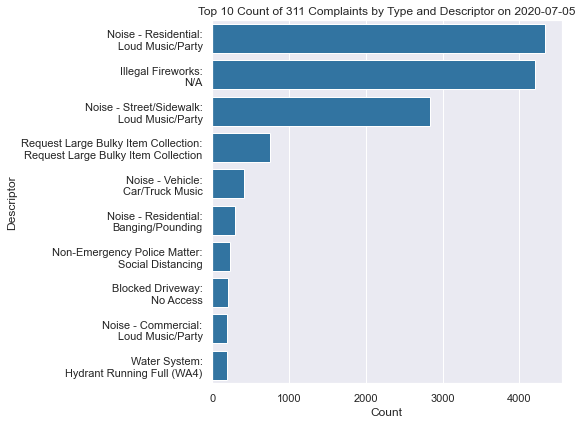

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

data = (
    df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='type_full',
    x='count',
    color='#1f77b4',
    ax=ax
)

# retrieve date string
date = data.head(1)['day'].str.split('T').values[0][0]
plt.title('Top 10 Count of 311 Complaints by Type and Descriptor on {}'.format(date))

plt.xlabel('Count')
plt.ylabel('Descriptor')
plt.tight_layout()
plt.savefig('figures/day-second.png', dpi=250, bbox_inches='tight')

## 3.3 Analyzing NYC 311 Datasets with the Most Downloads

In [24]:
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

# Reading in a list of dictionaries of our data into a pandas DataFrame
df = pd.DataFrame.from_records(client.datasets())
client.close()

print(df.shape)
df.head()

(3533, 8)


,resource,classification,metadata,permalink,link,owner,creator,preview_image_url
0,"{'name': 'Civil Service List (Active)', 'id': ...","{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/vx8i-nprf,https://data.cityofnewyork.us/City-Government/...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
1,"{'name': 'DOB Job Application Filings', 'id': ...","{'categories': ['economy', 'environment', 'hou...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/ic3t-wcy2,https://data.cityofnewyork.us/Housing-Developm...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
2,"{'name': 'For Hire Vehicles (FHV) - Active', '...","{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/8wbx-tsch,https://data.cityofnewyork.us/Transportation/F...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
3,"{'name': 'TLC New Driver Application Status', ...","{'categories': ['transportation', 'environment...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/dpec-ucu7,https://data.cityofnewyork.us/Transportation/T...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
4,{'name': 'For Hire Vehicles (FHV) - Active Dri...,"{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/xjfq-wh2d,https://data.cityofnewyork.us/Transportation/F...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN


In [25]:
# Reading the dictionary in the resource column into a pandas DataFrame
df = pd.DataFrame.from_records(df.resource)

print(df.shape)
df.head()

(3533, 25)


,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,columns_datatype,columns_description,columns_format,download_count,provenance,lens_view_type,lens_display_type,blob_mime_type,hide_from_data_json,publication_date
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-21T13:36:43.000Z,2016-06-14T21:12:15.000Z,...,"[Text, Text, Text, Calendar date, Calendar dat...",[A candidate’s last name as it appears on thei...,"[{'displayStyle': 'plain', 'align': 'left'}, {...",107056,official,tabular,table,None,False,2023-07-21T13:36:43.000Z
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-20T20:06:25.000Z,2013-04-18T15:18:56.000Z,...,"[Text, Text, Text, Text, Text, Number, Text, T...","[Other Description, Census Tract, Special Acti...","[{'align': 'right'}, {'align': 'right'}, {'ali...",87910,official,tabular,table,None,False,2020-06-22T18:23:35.000Z
2,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T13:41:24.000Z,2015-07-16T17:33:32.000Z,...,"[Text, Calendar date, Text, Text, Text, Text, ...","[Vehicle VIN Number, Last Date Updated, Permit...","[{'displayStyle': 'plain', 'align': 'left'}, {...",662536,official,tabular,table,None,False,2021-04-05T13:20:47.000Z
3,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T16:04:30.000Z,2016-05-17T18:43:43.000Z,...,"[Calendar date, Text, Calendar date, Text, Tex...","[The date you submitted your application., Dru...","[{'view': 'date', 'align': 'left'}, {'displayS...",73669,official,tabular,table,None,False,2019-12-17T18:44:57.000Z
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T13:40:22.000Z,2015-07-16T17:24:02.000Z,...,"[Number, Text, Calendar date, Text, Text, Text...","[FHV License Number\n, Driver Name\n\n, Expira...","[{'precisionStyle': 'standard', 'noCommas': 't...",706818,official,tabular,table,None,False,2023-07-21T13:40:22.000Z


In [26]:
# group count of datasets by agency
data = (
    df
    .groupby(by='attribution')['name']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'name':'count'})
    .head(20)
)

data.head()

,attribution,count
0,NYC Department of Education,543
1,Department of Education (DOE),257
2,Office of Technology and Innovation (OTI),214
3,Department of Transportation (DOT),186
4,Department of Parks and Recreation (DPR),180


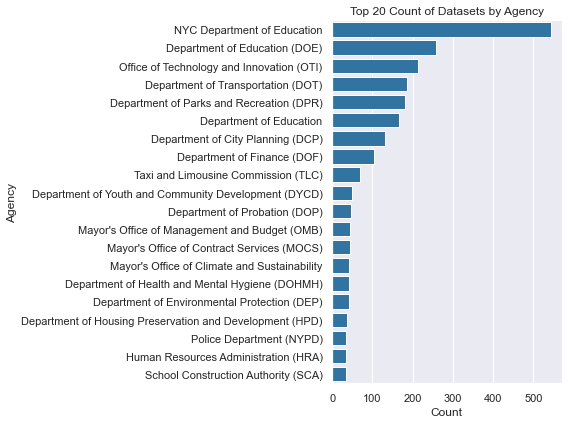

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='attribution',
    x='count',
    color='#1f77b4',
    ax=ax
)

plt.title('Top 20 Count of Datasets by Agency')
plt.xlabel('Count')
plt.ylabel('Agency')
plt.tight_layout()
plt.savefig('figures/datasets-count.png', dpi=250, bbox_inches='tight')

In [28]:
# Sorting the datasets by download_count
data = (
    df
    .loc[:, ['attribution', 'name', 'download_count']]
    .sort_values(by='download_count', ascending=False)
    .head(10)
)

data['full_name'] = data['attribution'] + ':\n' + data['name']
data['download_count'] = data['download_count'] / 1e6

data.head()

,attribution,name,download_count,full_name
41,Department of Youth and Community Development ...,Demographic Statistics By Zip Code,2.129272,Department of Youth and Community Development ...
1240,Department of Transportation (DOT),Overhead Electronic Signs,0.859194,Department of Transportation (DOT):\nOverhead ...
6,"311, DoITT",311 Service Requests from 2010 to Present,0.820536,"311, DoITT:\n311 Service Requests from 2010 to..."
4,Taxi and Limousine Commission (TLC),For Hire Vehicles (FHV) - Active Drivers,0.706818,Taxi and Limousine Commission (TLC):\nFor Hire...
2,Taxi and Limousine Commission (TLC),For Hire Vehicles (FHV) - Active,0.662536,Taxi and Limousine Commission (TLC):\nFor Hire...


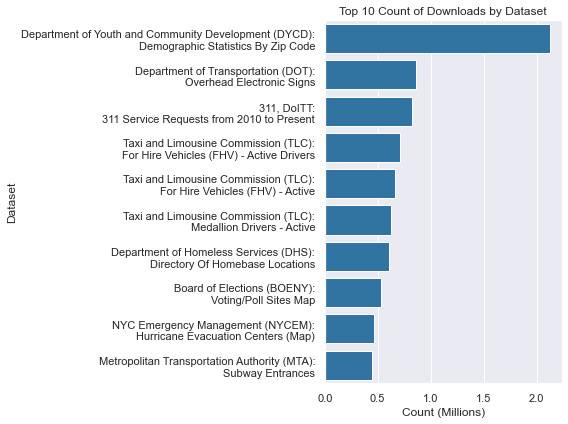

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='full_name',
    x='download_count',
    color='#1f77b4',
    ax=ax
)

plt.title('Top 10 Count of Downloads by Dataset')
plt.xlabel('Count (Millions)')
plt.ylabel('Dataset')
plt.tight_layout()
plt.savefig('figures/datasets-download.png', dpi=250, bbox_inches='tight')

In [31]:
data = (
    df
    .groupby(by='attribution')['download_count']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .head(20)
)

data['download_count'] = data['download_count'] / 1e6

data

,attribution,download_count
0,Taxi and Limousine Commission (TLC),2.757426
1,Department of Youth and Community Development ...,2.414747
2,Department of City Planning (DCP),1.902781
3,Department of Education (DOE),1.392672
4,Department of Transportation (DOT),1.323266
5,Department of Finance (DOF),1.088556
6,Department of Health and Mental Hygiene (DOHMH),0.869721
7,Department of Homeless Services (DHS),0.853844
8,Office of Technology and Innovation (OTI),0.853606
9,"311, DoITT",0.829200


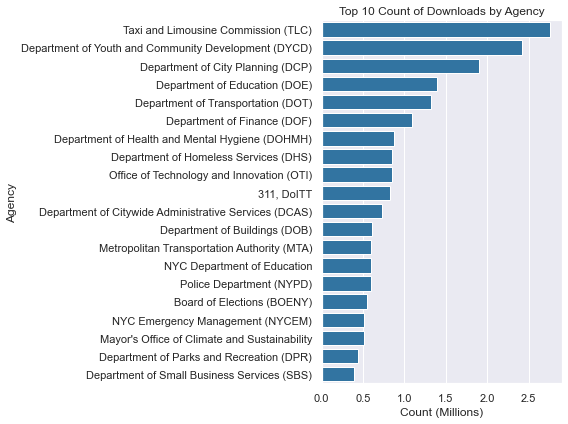

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='attribution',
    x='download_count',
    color='#1f77b4',
    ax=ax
)

plt.title('Top 10 Count of Downloads by Agency')
plt.xlabel('Count (Millions)')
plt.ylabel('Agency')
plt.tight_layout()
plt.savefig('figures/agency-downloads.png', dpi=250, bbox_inches='tight')

In [33]:
(df
 .groupby(by='attribution')['download_count']
 .mean()
 .sort_values(ascending=False)
 .round(0)
 .astype(int)
 .reset_index()
 .rename(columns={'download_count':'download_count_avg'})
 .head(20)
)

,attribution,download_count_avg
0,Board of Elections (BOENY),181743
1,Metropolitan Transportation Authority (MTA),150406
2,NYC Management Department (NYCEM),83060
3,"311, DoITT",69100
4,Department of Youth and Community Development ...,49281
5,NYC Emergency Management (NYCEM),39603
6,Taxi and Limousine Commission (TLC),39392
7,Office of Payroll Administration (OPA),39026
8,Department of Homeless Services (DHS),38811
9,Broadway Theater,37060


In [34]:
(df
 .groupby(by='attribution')['download_count']
 .median()
 .sort_values(ascending=False)
 .round(0)
 .astype(int)
 .reset_index()
 .rename(columns={'download_count':'download_count_median'})
 .head(20)
)

,attribution,download_count_median
0,NYC Management Department (NYCEM),83060
1,Metropolitan Transportation Authority (MTA),64929
2,Office of Payroll Administration (OPA),39026
3,Broadway Theater,37060
4,Mayor’s Office of Media and Entertainment (MOME),28896
5,Office of Administrative Trials and Hearings (...,26664
6,Office of the Mayor (OTM),20814
7,Department of Edcuation,19210
8,Department of Mental Health and Hygeine,17344
9,Department of Information Technology & Telecom...,16040


## 3. 4 Analyzing NYC 311 Datasets with the Most Page Views

In [35]:
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

# Reading in a list of dictionaries of our data into a pandas DataFrame
df = pd.DataFrame.from_records(client.datasets())
client.close()

df = pd.DataFrame.from_records(df.resource)

print(df.shape)
df.head()

(3533, 25)


,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,columns_datatype,columns_description,columns_format,download_count,provenance,lens_view_type,lens_display_type,blob_mime_type,hide_from_data_json,publication_date
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-21T13:36:43.000Z,2016-06-14T21:12:15.000Z,...,"[Text, Text, Text, Calendar date, Calendar dat...",[A candidate’s last name as it appears on thei...,"[{'displayStyle': 'plain', 'align': 'left'}, {...",107056,official,tabular,table,None,False,2023-07-21T13:36:43.000Z
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-20T20:06:25.000Z,2013-04-18T15:18:56.000Z,...,"[Text, Text, Text, Text, Text, Number, Text, T...","[Other Description, Census Tract, Special Acti...","[{'align': 'right'}, {'align': 'right'}, {'ali...",87910,official,tabular,table,None,False,2020-06-22T18:23:35.000Z
2,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T13:41:24.000Z,2015-07-16T17:33:32.000Z,...,"[Text, Calendar date, Text, Text, Text, Text, ...","[Vehicle VIN Number, Last Date Updated, Permit...","[{'displayStyle': 'plain', 'align': 'left'}, {...",662536,official,tabular,table,None,False,2021-04-05T13:20:47.000Z
3,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T16:04:30.000Z,2016-05-17T18:43:43.000Z,...,"[Calendar date, Text, Calendar date, Text, Tex...","[The date you submitted your application., Dru...","[{'view': 'date', 'align': 'left'}, {'displayS...",73669,official,tabular,table,None,False,2019-12-17T18:44:57.000Z
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T13:40:22.000Z,2015-07-16T17:24:02.000Z,...,"[Number, Text, Calendar date, Text, Text, Text...","[FHV License Number\n, Driver Name\n\n, Expira...","[{'precisionStyle': 'standard', 'noCommas': 't...",706818,official,tabular,table,None,False,2023-07-21T13:40:22.000Z


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533 entries, 0 to 3532
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 3533 non-null   object
 1   id                   3533 non-null   object
 2   parent_fxf           3533 non-null   object
 3   description          3533 non-null   object
 4   attribution          3319 non-null   object
 5   attribution_link     410 non-null    object
 6   contact_email        0 non-null      object
 7   type                 3533 non-null   object
 8   updatedAt            3533 non-null   object
 9   createdAt            3533 non-null   object
 10  metadata_updated_at  3533 non-null   object
 11  data_updated_at      3308 non-null   object
 12  page_views           3533 non-null   object
 13  columns_name         3533 non-null   object
 14  columns_field_name   3533 non-null   object
 15  columns_datatype     3533 non-null   object
 16  column

In [37]:
df['page_views'].head()

0    {'page_views_last_week': 67322, 'page_views_la...
1    {'page_views_last_week': 987, 'page_views_last...
2    {'page_views_last_week': 17094, 'page_views_la...
3    {'page_views_last_week': 279, 'page_views_last...
4    {'page_views_last_week': 6728, 'page_views_las...
Name: page_views, dtype: object

In [38]:
# we need to explode those columns from that dictionary to separate columns in df
df = pd.concat(
    [df.drop(['page_views'], axis=1), df['page_views'].apply(pd.Series)],
    axis=1
)

df.head()

,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,lens_display_type,blob_mime_type,hide_from_data_json,publication_date,page_views_last_week,page_views_last_month,page_views_total,page_views_last_week_log,page_views_last_month_log,page_views_total_log
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-21T13:36:43.000Z,2016-06-14T21:12:15.000Z,...,table,None,False,2023-07-21T13:36:43.000Z,67322.0,98935.0,4702612.0,16.038812,16.594208,22.165031
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-20T20:06:25.000Z,2013-04-18T15:18:56.000Z,...,table,None,False,2020-06-22T18:23:35.000Z,987.0,3913.0,4591854.0,9.948367,11.934428,22.130646
2,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T13:41:24.000Z,2015-07-16T17:33:32.000Z,...,table,None,False,2021-04-05T13:20:47.000Z,17094.0,63846.0,3863964.0,14.061287,15.962331,21.881651
3,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T16:04:30.000Z,2016-05-17T18:43:43.000Z,...,table,None,False,2019-12-17T18:44:57.000Z,279.0,1177.0,3420038.0,8.129283,10.202124,21.705581
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-21T13:40:22.000Z,2015-07-16T17:24:02.000Z,...,table,None,False,2023-07-21T13:40:22.000Z,6728.0,23771.0,2558850.0,12.716176,14.536976,21.287065


In [39]:
data = (
    df
    .loc[:, ['attribution', 'name', 'page_views_total']]
    .sort_values(by='page_views_total', ascending=False)
    .head(10)
)

data['full_name'] = data['attribution'] + ':\n' + data['name']
data['page_views_total'] = data['page_views_total'] / 1e6

data

,attribution,name,page_views_total,full_name
0,Department of Citywide Administrative Services...,Civil Service List (Active),4.702612,Department of Citywide Administrative Services...
1,Department of Buildings (DOB),DOB Job Application Filings,4.591854,Department of Buildings (DOB):\nDOB Job Applic...
2,Taxi and Limousine Commission (TLC),For Hire Vehicles (FHV) - Active,3.863964,Taxi and Limousine Commission (TLC):\nFor Hire...
3,Taxi and Limousine Commission (TLC),TLC New Driver Application Status,3.420038,Taxi and Limousine Commission (TLC):\nTLC New ...
4,Taxi and Limousine Commission (TLC),For Hire Vehicles (FHV) - Active Drivers,2.558850,Taxi and Limousine Commission (TLC):\nFor Hire...
5,Department of Citywide Administrative Services...,Civil Service List Certification,1.280783,Department of Citywide Administrative Services...
6,"311, DoITT",311 Service Requests from 2010 to Present,1.189307,"311, DoITT:\n311 Service Requests from 2010 to..."
7,Department of Buildings (DOB),DOB Permit Issuance,0.851017,Department of Buildings (DOB):\nDOB Permit Iss...
8,Police Department (NYPD),Motor Vehicle Collisions - Crashes,0.764417,Police Department (NYPD):\nMotor Vehicle Colli...
9,Office of Payroll Administration (OPA),Citywide Payroll Data (Fiscal Year),0.746142,Office of Payroll Administration (OPA):\nCityw...


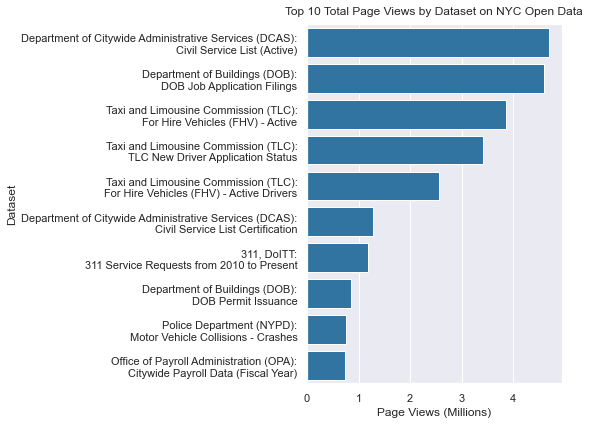

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='full_name',
    x='page_views_total',
    color='#1f77b4',
    ax=ax
)

plt.title(
    'Top 10 Total Page Views by Dataset on NYC Open Data',
    fontsize=12, pad=10)
plt.xlabel('Page Views (Millions)')
plt.ylabel('Dataset')
plt.tight_layout()
plt.savefig('figures/pageviews-dataset.png', dpi=250, bbox_inches='tight')

## 4. Analyzing NYC 311 Street Flooding Complaints

### 4.1 Searching the dataset for the word "flood" in the complaint_type field

In [41]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select complaint_type and count of complaint_type grouped by compaint_type,
where the word "flood" is in compplaint_type,
sort count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type, 
    count(unique_key) AS count
WHERE 
    LOWER(complaint_type) LIKE '%flood%'
GROUP BY 
    complaint_type
ORDER BY 
    count(unique_key) DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (0, 0)


""


### 4.2 Searching the dataset for the word "flood" in the descriptor field

In [42]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select complaint_type and count of complaint_type grouped by compaint_type,
where the word "flood" is in descriptor,
sort count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type,
    descriptor,
    count(unique_key) AS count
WHERE 
    LOWER(descriptor) LIKE '%flood%'
GROUP BY 
    complaint_type, descriptor
ORDER BY 
    count(unique_key) DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df

shape of data: (11, 3)


,complaint_type,descriptor,count
0,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),108332
1,Sewer,Street Flooding (SJ),36096
2,Street Light Condition,Flood Light Lamp Out,6418
3,Sewer,Highway Flooding (SH),3077
4,Street Light Condition,Flood Light Lamp Cycling,2573
5,OEM Literature Request,Ready NY - Flooding,271
6,Street Light Condition,Flood Light Lamp Dayburning,223
7,Street Light Condition,Flood Light Lamp Missing,206
8,Street Light Condition,Flood Light Lamp Dim,184
9,Sewer,RAIN GARDEN FLOODING (SRGFLD),152


### 4. 3 Displaying the highest number of street flooding complaints by day

In [43]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=100
)

""" SoQL query string below:
Select the day and the count day columns grouped by day,
where the descriptor is Street Flooding (SJ),
sort the count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) as day, 
    count(created_date) AS count
WHERE 
    descriptor == 'Street Flooding (SJ)'
GROUP BY 
    day
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (1000, 2)


,day,count
0,2021-09-02T00:00:00.000,350
1,2021-09-01T00:00:00.000,344
2,2022-12-23T00:00:00.000,308
3,2017-05-05T00:00:00.000,247
4,2014-12-09T00:00:00.000,226


In [44]:
day = df.head(1)['day'][0].split('T')[0]
count = df.head(1)['count'][0]

print('The highest day of Street Flooding Complaints \
was on {} with {} total number of complaints.'.format(day, count))

The highest day of Street Flooding Complaints was on 2021-09-02 with 350 total number of complaints.


Let's use the date above to see other complaint types represented on that date.

In [45]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2021-09-02T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (480, 4)


,day,complaint_type,descriptor,count
0,2021-09-02T00:00:00.000,Sewer,Sewer Backup (Use Comments) (SA),2372
1,2021-09-02T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,1350
2,2021-09-02T00:00:00.000,WATER LEAK,HEAVY FLOW,564
3,2021-09-02T00:00:00.000,Traffic Signal Condition,Controller,391
4,2021-09-02T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,358
5,2021-09-02T00:00:00.000,Sewer,Street Flooding (SJ),350
6,2021-09-02T00:00:00.000,PAINT/PLASTER,CEILING,321
7,2021-09-02T00:00:00.000,Blocked Driveway,No Access,313
8,2021-09-02T00:00:00.000,Damaged Tree,Branch or Limb Has Fallen Down,303
9,2021-09-02T00:00:00.000,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),295


Let's use the second highest event (date rank 1 and 2 are one day apart, so we can consider as one single event) above to see other complaint types represented on that date.

date of `'2022-12-23T00:00:00.000'`

In [46]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2022-12-23T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head(10)

shape of data: (424, 4)


,day,complaint_type,descriptor,count
0,2022-12-23T00:00:00.000,HEAT/HOT WATER,ENTIRE BUILDING,1524
1,2022-12-23T00:00:00.000,HEAT/HOT WATER,APARTMENT ONLY,870
2,2022-12-23T00:00:00.000,Blocked Driveway,No Access,373
3,2022-12-23T00:00:00.000,Traffic Signal Condition,Controller,322
4,2022-12-23T00:00:00.000,Illegal Parking,Blocked Hydrant,311
5,2022-12-23T00:00:00.000,Sewer,Street Flooding (SJ),308
6,2022-12-23T00:00:00.000,Noise - Residential,Loud Music/Party,250
7,2022-12-23T00:00:00.000,Noise - Residential,Banging/Pounding,210
8,2022-12-23T00:00:00.000,Illegal Parking,Posted Parking Sign Violation,187
9,2022-12-23T00:00:00.000,Damaged Tree,Entire Tree Has Fallen Down,167


### 4.4 Selecting the rows and columns where the descriptor field = 'Street Flooding'

Note: `WARNING:root:Requests made without an app_token will be subject to strict throttling limits.`

In [47]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=100
)

""" SoQL query string below:
Select all columns where the descriptor is Street Flooding(SJ),
sort the created date field in descending order and limit our records to 1,000
"""

query = """
SELECT 
    *
WHERE 
    descriptor == 'Street Flooding (SJ)'
ORDER BY 
    created_date DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

df = pd.DataFrame(results)

print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (1000, 30)


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,park_facility_name,park_borough,latitude,longitude,location,intersection_street_1,intersection_street_2,closed_date,resolution_description,resolution_action_updated_date
0,58234412,2023-07-18T20:08:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10473,800 BOLTON AVENUE,BOLTON AVENUE,LAFAYETTE AVE,...,Unspecified,BRONX,40.82221080548931,-73.85932846516333,"{'latitude': '40.82221080548931', 'longitude':...",NaN,NaN,NaN,NaN,NaN
1,58241178,2023-07-18T17:56:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11385,NaN,NaN,NaN,...,Unspecified,QUEENS,40.702042628316065,-73.85026266467501,"{'latitude': '40.702042628316065', 'longitude'...",FREEDOM DRIVE,MYRTLE AVENUE,NaN,NaN,NaN
2,58237100,2023-07-18T16:53:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11432,172-03 HIGHLAND AVENUE,HIGHLAND AVENUE,KINGSTON PL,...,Unspecified,QUEENS,40.713078025858366,-73.79124626094924,"{'latitude': '40.713078025858366', 'longitude'...",NaN,NaN,NaN,NaN,NaN
3,58234413,2023-07-18T16:47:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11692,70-20 ROCKAWAY BEACH BOULEVARD,ROCKAWAY BEACH BOULEVARD,CORAL REEF WAY,...,Unspecified,QUEENS,40.58956376846801,-73.79967588630932,"{'latitude': '40.58956376846801', 'longitude':...",NaN,NaN,NaN,NaN,NaN
4,58239758,2023-07-18T16:11:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10033,NaN,NaN,NaN,...,Unspecified,MANHATTAN,40.85179479152171,-73.93009926586655,"{'latitude': '40.85179479152171', 'longitude':...",AUDUBON AVENUE,WEST 186 STREET,NaN,NaN,NaN
